# **Introduction**

In the [paper from UCLA](https://escholarship.org/uc/item/3rs9b3d6) regarding XGBoost and Loan Predictions, they using many different data balancing methods to make sure their data is producing the best results. We want to improve upon the XGBoost algorithm in the UCLA paper by reimplementing the UCLA XGBoost algorithm with different data balancing techniques (K-Fold Cross Validation and Stratified K-Fold Cross Validation). We would like to observe how these data balancing techniques compare against eachother and compare against the data balancing techniquesin the UCLA paper. Further, we will also implement a more simplified version of XGBoost using the cross validation techniques. We will also implement random forest and logisitic regression with the corss validation techniques and compare all of these algorithms to determine the best performing.

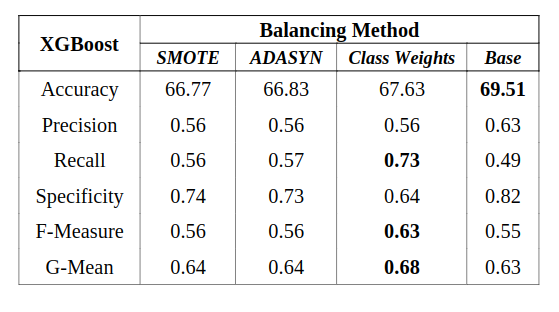

In [1]:
from PIL import Image
Image.open("images/UCLAarticle_performance.png")

These are the results from the UCLA XGBoost algorithm. As can be seen, UCLA's XGBoost with class weights performs the best

In [2]:
import pandas as pd

## Load Data

Below, we are viewing the CSV file as a dataframe. We can observe the various features that will help our XGBoost model predict. The data being loaded in was modified a bit. The original data was the training data, the test data without target feature and the target features for the test data. I combined the test data without target features with its target features in order to have the data more organized. The original data from Kaggle is the in Original_CSV_Data_From_Kaggle folder while the Edited_CSV_Files are the data after the modification mentioned above. 

In [3]:
test_data = pd.read_csv('Edited_CSV_Files/TestData.csv')
train_data = pd.read_csv('Edited_CSV_Files/TrainingData.csv')
train_data.head()

,ID,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [4]:
test_data.head()

,ID,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13,0
1,2,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10,0
2,3,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14,1
3,4,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,3,12,0
4,5,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,13,11,0


To determine how many rows and columns each dataframe has, we can call the shape function. The first value in the tuple is the amount of rows while the second value is the amount of columns.

In [5]:
train_data.shape

(252000, 13)

In [6]:
test_data.shape

(28000, 13)

## Combining data into one huge dataset 

Our data is divided into a train set and a test set. To prepare the data for Stratified K-Fold Cross Validation, we must combine the train and test set. This is due to the fact that K-Fold Cross Validation will split the data into multiple groups and choose one as a train set and another as a test set for us. Then, we loop through our XGBoost algorithm on all the different groups to obtain the best accuracy. This will help show that our model is predicting well since it is being tested against "unknown" (It is called unknown data because the algorithm is being trained on different data at each iteration and then predicting on different data each iteration) data and therefore justifing it's accuracy.

In [7]:
train_test_data = [train_data, test_data]

all_data = pd.concat(train_test_data)

# we do not need the ID column since pandas already numbers the rows for us
all_data = all_data.drop(columns = ['ID']) 
                                                
all_data

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...
27995,9955481,57,13,single,rented,no,Statistician,Eluru[25],Andhra Pradesh,5,10,0
27996,2917765,47,9,single,rented,no,Technical writer,Ratlam,Madhya Pradesh,9,14,1
27997,8082415,24,5,single,rented,no,Lawyer,Mira-Bhayandar,Maharashtra,4,13,0
27998,9474180,51,13,single,rented,yes,Chartered Accountant,Bhilai,Chhattisgarh,13,14,0


In [8]:
all_data.shape

(280000, 12)

This table has 280,000 rows. Thjis makes sense because the train set had 252,000 rows and the test set had 28,000 rows. Together, that equals 280,000.

## Check for missing values

In [9]:
all_data.isnull().sum() #if all columns sum to zero, it means there are no missing values/nulls

Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

# **Data Preprocessing** 

## Scaling Data 

Scaling data is an important process in the data science process. We must scale our numeric data to not give more weight to values that are greater than smaller values which may not be true (ex: an age column would have an issue in this regard). We will use the Minimum Maximum Scaler formula here which will scale our numeric data between 0 and 1. We should remove the categorical data and scale the numeric data and put the dataframe back together. Here is the min max formula we will be using below:

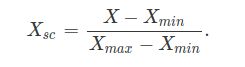

In [10]:
Image.open("images/Min_Max_Scaler_Formula.png")

In [11]:
column_labels = ["Profession", "CITY", "STATE","Married/Single", "House_Ownership", "Car_Ownership"]
data_numeric = all_data.drop(columns = column_labels) # to have numeric data separate from categorical in order to perform scaling
data_numeric

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1303834,23,3,3,13,0
1,7574516,40,10,9,13,0
2,3991815,66,4,4,10,0
3,6256451,41,2,2,12,1
4,5768871,47,11,3,14,1
...,...,...,...,...,...,...
27995,9955481,57,13,5,10,0
27996,2917765,47,9,9,14,1
27997,8082415,24,5,4,13,0
27998,9474180,51,13,13,14,0


In [12]:
data_categorical = all_data[column_labels] # to have the categorical data separate from numeric
data_categorical

,Profession,CITY,STATE,Married/Single,House_Ownership,Car_Ownership
0,Mechanical_engineer,Rewa,Madhya_Pradesh,single,rented,no
1,Software_Developer,Parbhani,Maharashtra,single,rented,no
2,Technical_writer,Alappuzha,Kerala,married,rented,no
3,Software_Developer,Bhubaneswar,Odisha,single,rented,yes
4,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,single,rented,no
...,...,...,...,...,...,...
27995,Statistician,Eluru[25],Andhra Pradesh,single,rented,no
27996,Technical writer,Ratlam,Madhya Pradesh,single,rented,no
27997,Lawyer,Mira-Bhayandar,Maharashtra,single,rented,no
27998,Chartered Accountant,Bhilai,Chhattisgarh,single,rented,yes


In [13]:
data_numeric_scaled = (data_numeric-data_numeric.min())/(data_numeric.max()-data_numeric.min())
data_numeric_scaled

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,0.129487,0.034483,0.15,0.214286,0.75,0.0
1,0.757206,0.327586,0.50,0.642857,0.75,0.0
2,0.398564,0.775862,0.20,0.285714,0.00,0.0
3,0.625263,0.344828,0.10,0.142857,0.50,1.0
4,0.576454,0.448276,0.55,0.214286,1.00,1.0
...,...,...,...,...,...,...
27995,0.995550,0.620690,0.65,0.357143,0.00,0.0
27996,0.291047,0.448276,0.45,0.642857,1.00,1.0
27997,0.808049,0.051724,0.25,0.285714,0.75,0.0
27998,0.947370,0.517241,0.65,0.928571,1.00,0.0


In [14]:
all_data_scaled = pd.concat([data_categorical, data_numeric_scaled], axis=1)
all_data_scaled

,Profession,CITY,STATE,Married/Single,House_Ownership,Car_Ownership,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,Mechanical_engineer,Rewa,Madhya_Pradesh,single,rented,no,0.129487,0.034483,0.15,0.214286,0.75,0.0
1,Software_Developer,Parbhani,Maharashtra,single,rented,no,0.757206,0.327586,0.50,0.642857,0.75,0.0
2,Technical_writer,Alappuzha,Kerala,married,rented,no,0.398564,0.775862,0.20,0.285714,0.00,0.0
3,Software_Developer,Bhubaneswar,Odisha,single,rented,yes,0.625263,0.344828,0.10,0.142857,0.50,1.0
4,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,single,rented,no,0.576454,0.448276,0.55,0.214286,1.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
27995,Statistician,Eluru[25],Andhra Pradesh,single,rented,no,0.995550,0.620690,0.65,0.357143,0.00,0.0
27996,Technical writer,Ratlam,Madhya Pradesh,single,rented,no,0.291047,0.448276,0.45,0.642857,1.00,1.0
27997,Lawyer,Mira-Bhayandar,Maharashtra,single,rented,no,0.808049,0.051724,0.25,0.285714,0.75,0.0
27998,Chartered Accountant,Bhilai,Chhattisgarh,single,rented,yes,0.947370,0.517241,0.65,0.928571,1.00,0.0


Now, the categorical data and the scaled numeric data are back in the same dataframe.

## One Hot Encoding

Some of the columns such as profession, city and home_ownership in the dataframe are not numeric or binary data. In order to build a sufficient ML model, we must change our categorical data into numeric or binary data. There are two popular methods of encoding: label encoding and one hot encoding. Label encoding is ideal when using ordinal data but in our case, all the data we are changing is categorical data so we would want to use one hot encoding which is best for this situation. One hot encoding will convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns which will classify all the categorical data as binary data. Below we will implement one hot encoding using the pandas library get_dummies() function. 

In [15]:

column_labels = ["Profession", "CITY", "STATE","Married/Single", "House_Ownership", "Car_Ownership"]
data_categorical = all_data_scaled.copy()

data_one_hot_encoded = pd.get_dummies(data_categorical, columns = column_labels)


The code below changes the columna that may have a bracket, comma or inequality sign in their label to an underscore. This will prevent errors later when trying to run our data through the algorithm.

In [16]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
data_one_hot_encoded.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col 
                                for col in data_one_hot_encoded.columns.values]

Let us view the new columns after the change from categorical data to binary data. 

In [17]:
data_one_hot_encoded.columns.tolist()

['Income',
 'Age',
 'Experience',
 'CURRENT_JOB_YRS',
 'CURRENT_HOUSE_YRS',
 'Risk_Flag',
 'Profession_Air traffic controller',
 'Profession_Air_traffic_controller',
 'Profession_Analyst',
 'Profession_Architect',
 'Profession_Army officer',
 'Profession_Army_officer',
 'Profession_Artist',
 'Profession_Aviator',
 'Profession_Biomedical Engineer',
 'Profession_Biomedical_Engineer',
 'Profession_Chartered Accountant',
 'Profession_Chartered_Accountant',
 'Profession_Chef',
 'Profession_Chemical engineer',
 'Profession_Chemical_engineer',
 'Profession_Civil engineer',
 'Profession_Civil servant',
 'Profession_Civil_engineer',
 'Profession_Civil_servant',
 'Profession_Comedian',
 'Profession_Computer hardware engineer',
 'Profession_Computer operator',
 'Profession_Computer_hardware_engineer',
 'Profession_Computer_operator',
 'Profession_Consultant',
 'Profession_Dentist',
 'Profession_Design Engineer',
 'Profession_Design_Engineer',
 'Profession_Designer',
 'Profession_Drafter',
 'Profe

As can be seen above, there are a lot more columns. This is necessary because we cannot build learning models from categorical data. There are 458 columns now as opposed to 11 before to account for the categorical data.

# **Building Our Model Like the XGBoost model in the UCLA paper**

Before building the model, lets split our target feature from our other features

In [18]:
X = data_one_hot_encoded.drop(columns = ['Risk_Flag'])
X

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Profession_Air traffic controller,Profession_Air_traffic_controller,Profession_Analyst,Profession_Architect,Profession_Army officer,...,STATE_Uttarakhand,STATE_West Bengal,STATE_West_Bengal,Married/Single_married,Married/Single_single,House_Ownership_norent_noown,House_Ownership_owned,House_Ownership_rented,Car_Ownership_no,Car_Ownership_yes
0,0.129487,0.034483,0.15,0.214286,0.75,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
1,0.757206,0.327586,0.50,0.642857,0.75,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
2,0.398564,0.775862,0.20,0.285714,0.00,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
3,0.625263,0.344828,0.10,0.142857,0.50,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
4,0.576454,0.448276,0.55,0.214286,1.00,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0.995550,0.620690,0.65,0.357143,0.00,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
27996,0.291047,0.448276,0.45,0.642857,1.00,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
27997,0.808049,0.051724,0.25,0.285714,0.75,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
27998,0.947370,0.517241,0.65,0.928571,1.00,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1


In [19]:
Y = pd.DataFrame(data_one_hot_encoded['Risk_Flag'])

Here, we are implementing our algorithm. The XGBoost algorithm is a decision-tree-based ensemble machine learning algorithm that uses a gradient boosting to increase efficiency. Our algorithm will have the same parameters as the XGBoost algorithm in the paper.

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


#Parameters filled for the XGBClassifier are the same as in the UCLA paper
xgb_model = XGBClassifier(n_estimators=300, max_depth = 3, learning_rate = 0.05, use_label_encoder=False, eval_metric='mlogloss', scale_pos_weight=7.1)


accuracy_list = []
recall_list = []
precision_list = []
f1_score_list = []

## K Fold Cross Validation for XGBoost from UCLA Paper

Cross-validation is a statistical method used to evaluate the skill of machine learning models. It uses resampling techniques to evaluate a model. K Fold Cross Validation has a single parameter called k that refers to the number of groups that a given data sample is to be split into. It will run the model on each group which will have its own train and test set and then it will store the evaluation metrics. The model is then discarded and relearned and evaluated using the next group and so on until there are no more groups. The difference between KFold and Stratified KFold which we will implement below is that KFold will randomly sample the data to form the groups. In Stratified K-Fold, the sampling is still selected at random but the proportion of observations regarding the target values remain the same.

Below we implement K-Fold cross validation. We will run it 3 times, where k=3, k=5 and k=10. We chose these values as they are the most common splits used and studied in experimentation.

In [21]:
from sklearn.model_selection import KFold
import numpy as np
kfcv3 = KFold(n_splits=3, random_state = 1, shuffle = True)
kfcv5 = KFold(n_splits=5, random_state = 1, shuffle = True)
kfcv10 = KFold(n_splits=10,  random_state = 1, shuffle = True)

### 3-Fold Cross Validation

In [22]:
%%time
for train, test in kfcv3.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    xgb_model.fit(x_train_one_fold, y_train_one_fold)
    preds = xgb_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 26min 15s, sys: 1min 39s, total: 27min 55s
Wall time: 1min 10s


In [23]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(3):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.63098                0.55311                0.61597                0.51918
0.63983                0.54855                0.60497                0.51871
0.61439                0.5483                0.60902                0.50661


In [24]:
avg_accuracy_kfcv3 = sum(accuracy_list) / len(accuracy_list)
avg_precision_kfcv3 = sum(precision_list) / len(precision_list)
avg_recall_kfcv3 = sum(recall_list) / len(recall_list)
avg_f1_score_kfcv3 = sum(f1_score_list) / len(f1_score_list)

In [25]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### 5-Fold Cross Validation

In [26]:
%%time
for train, test in kfcv5.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    xgb_model.fit(x_train_one_fold, y_train_one_fold)
    preds = xgb_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 51min 23s, sys: 2min 44s, total: 54min 8s
Wall time: 2min 17s


In [27]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(5):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.62809                0.55454                0.61984                0.51898
0.63425                0.54907                0.60577                0.51746
0.62498                0.54737                0.60426                0.51139
0.63186                0.55174                0.61439                0.51755
0.62204                0.54723                0.60635                0.50879


In [28]:
avg_accuracy_kfcv5 = sum(accuracy_list) / len(accuracy_list)
avg_precision_kfcv5 = sum(precision_list) / len(precision_list)
avg_recall_kfcv5 = sum(recall_list) / len(recall_list)
avg_f1_score_kfcv5 = sum(f1_score_list) / len(f1_score_list)

In [29]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### 10-Fold Cross Validation

In [30]:
%%time
for train, test in kfcv10.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    xgb_model.fit(x_train_one_fold, y_train_one_fold)
    preds = xgb_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 1h 55min 28s, sys: 6min 13s, total: 2h 1min 42s
Wall time: 5min 8s


In [31]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(10):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.62564                0.55187                0.61468                0.51533
0.63782                0.55282                0.61364                0.52226
0.62504                0.55416                0.6184                0.51778
0.63361                0.54744                0.60253                0.51558
0.61529                0.54798                0.60769                0.50706
0.6335                0.54808                0.60392                0.51614
0.62425                0.55083                0.61394                0.51308
0.62329                0.55191                0.61537                0.51416
0.61721                0.54537                0.60273                0.50499
0.63275                0.54761                0.60558                0.51395


In [32]:
avg_accuracy_kfcv10 = sum(accuracy_list) / len(accuracy_list)
avg_precision_kfcv10 = sum(precision_list) / len(precision_list)
avg_recall_kfcv10 = sum(recall_list) / len(recall_list)
avg_f1_score_kfcv10 = sum(f1_score_list) / len(f1_score_list)

In [33]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### Visualization of Results for XGBoost from UCLA paper using K-Fold 

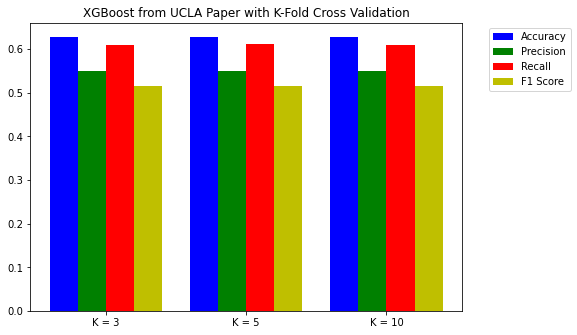

In [34]:
import matplotlib.pyplot as plt
data = [[avg_accuracy_kfcv3, avg_accuracy_kfcv5, avg_accuracy_kfcv10],
       [avg_precision_kfcv3, avg_precision_kfcv5, avg_precision_kfcv10],
       [avg_recall_kfcv3, avg_recall_kfcv5, avg_recall_kfcv10],
       [avg_f1_score_kfcv3, avg_f1_score_kfcv5, avg_f1_score_kfcv10]]
x = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(x + 0.0, data[0], color = 'b', width = 0.2)
ax.bar(x + 0.2, data[1], color = 'g', width = 0.2)
ax.bar(x + 0.4, data[2], color = 'r', width = 0.2)
ax.bar(x + 0.6, data[3], color = 'y', width = 0.2)
ax.set_xticks(x + 0.3)
ax.set_title('XGBoost from UCLA Paper with K-Fold Cross Validation')
ax.set_xticklabels(['K = 3', 'K = 5', 'K = 10'])
ax.legend(labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score'], bbox_to_anchor=(1.05, 1), loc='upper left')

## Stratified K-Fold Cross Validation for XGBoost from UCLA paper

Stratified K-Fold, as explained above, is a type of cross validation technique that will split the data into K Folds while maintaining proportion of the target values as is the main dataframe in all the k groups. Below is the implementation using k=3, k=5 and k=10.

In [35]:
from sklearn.model_selection import StratifiedKFold
skfcv3 = StratifiedKFold(n_splits=3,random_state=1, shuffle=True)
skfcv5 = StratifiedKFold(n_splits=5,random_state=1, shuffle=True)
skfcv10 = StratifiedKFold(n_splits=10,random_state=1, shuffle=True)

### Stratified 3-Fold Cross Validation

In [36]:
%%time
for train, test in skfcv3.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    xgb_model.fit(x_train_one_fold, y_train_one_fold)
    preds = xgb_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 26min 18s, sys: 1min 21s, total: 27min 40s
Wall time: 1min 9s


In [37]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(3):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.62498                0.54938                0.60915                0.51291
0.63638                0.55007                0.60915                0.51848
0.63015                0.54799                0.60521                0.51404


In [38]:
avg_accuracy_skfcv3 = sum(accuracy_list) / len(accuracy_list)
avg_precision_skfcv3 = sum(precision_list) / len(precision_list)
avg_recall_skfcv3 = sum(recall_list) / len(recall_list)
avg_f1_score_skfcv3 = sum(f1_score_list) / len(f1_score_list)

In [39]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### Stratified 5-Fold Cross Validation

In [40]:
%%time
for train, test in skfcv5.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    xgb_model.fit(x_train_one_fold, y_train_one_fold)
    preds = xgb_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 51min 14s, sys: 2min 36s, total: 53min 51s
Wall time: 2min 16s


In [41]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(5):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.62523                0.54902                0.6083                0.51272
0.64598                0.55337                0.61519                0.52538
0.63036                0.55088                0.61193                0.51653
0.62238                0.54773                0.60564                0.5104
0.63386                0.55036                0.6102                0.51764


In [42]:
avg_accuracy_skfcv5 = sum(accuracy_list) / len(accuracy_list)
avg_precision_skfcv5 = sum(precision_list) / len(precision_list)
avg_recall_skfcv5 = sum(recall_list) / len(recall_list)
avg_f1_score_skfcv5 = sum(f1_score_list) / len(f1_score_list)

In [43]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### Stratified 10-Fold Cross Validation

In [44]:
%%time
for train, test in skfcv10.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    xgb_model.fit(x_train_one_fold, y_train_one_fold)
    preds = xgb_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 1h 55min 30s, sys: 5min 22s, total: 2h 52s
Wall time: 5min 5s


In [45]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(10):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.62975                0.55008                0.61016                0.51559
0.62682                0.54965                0.60954                0.51395
0.62593                0.55028                0.61114                0.51407
0.633                0.54818                0.60524                0.51543
0.63114                0.55049                0.61089                0.51655
0.63046                0.54911                0.60777                0.51511
0.62807                0.54678                0.60268                0.51212
0.62271                0.5474                0.60484                0.51029
0.63668                0.54873                0.60597                0.51747
0.6255                0.55021                0.61102                0.51382


In [46]:
avg_accuracy_skfcv10 = sum(accuracy_list) / len(accuracy_list)
avg_precision_skfcv10 = sum(precision_list) / len(precision_list)
avg_recall_skfcv10 = sum(recall_list) / len(recall_list)
avg_f1_score_skfcv10 = sum(f1_score_list) / len(f1_score_list)

In [47]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### Visualization of Results for XGBoost from UCLA paper using Stratified K-Fold 

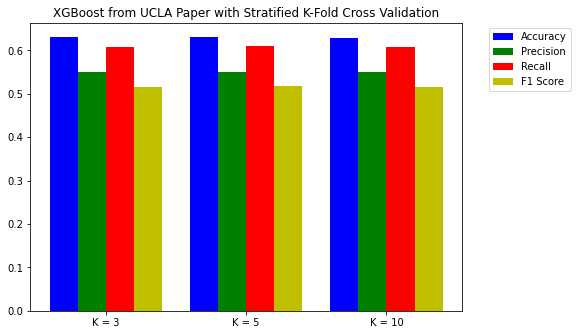

In [48]:
import matplotlib.pyplot as plt
data = [[avg_accuracy_skfcv3, avg_accuracy_skfcv5, avg_accuracy_skfcv10],
       [avg_precision_skfcv3, avg_precision_skfcv5, avg_precision_skfcv10],
       [avg_recall_skfcv3, avg_recall_skfcv5, avg_recall_skfcv10],
       [avg_f1_score_skfcv3, avg_f1_score_skfcv5, avg_f1_score_skfcv10]]
x = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(x + 0.0, data[0], color = 'b', width = 0.2)
ax.bar(x + 0.2, data[1], color = 'g', width = 0.2)
ax.bar(x + 0.4, data[2], color = 'r', width = 0.2)
ax.bar(x + 0.6, data[3], color = 'y', width = 0.2)
ax.set_xticks(x + 0.3)
ax.set_title('XGBoost from UCLA Paper with Stratified K-Fold Cross Validation')
ax.set_xticklabels(['K = 3', 'K = 5', 'K = 10'])
ax.legend(labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score'], bbox_to_anchor=(1.05, 1), loc='upper left')

# **Building the Standard XGBoost model**

Here, we are implementing the standard XGBoost algorithm. The difference between this algorithm and the previous one is that this one contains less parameters.

In [49]:
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', scale_pos_weight=7.1)


accuracy_list = []
recall_list = []
precision_list = []
f1_score_list = []

## K-Fold Cross Validation for Standard XGBoost

In [50]:
from sklearn.model_selection import KFold
import numpy as np
kfcv3 = KFold(n_splits=3, random_state = 1, shuffle = True)
kfcv5 = KFold(n_splits=5, random_state = 1, shuffle = True)
kfcv10 = KFold(n_splits=10,  random_state = 1, shuffle = True)

### 3-Fold Cross Validation

In [51]:
%%time
for train, test in kfcv3.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    xgb_model.fit(x_train_one_fold, y_train_one_fold)
    preds = xgb_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 15min 55s, sys: 1min 6s, total: 17min 2s
Wall time: 43.4 s


In [52]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(3):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.74634                0.6213                0.73751                0.6273
0.75656                0.62402                0.73877                0.63335
0.74802                0.61867                0.73464                0.62489


In [53]:
avg_accuracy_kfcv3 = sum(accuracy_list) / len(accuracy_list)
avg_precision_kfcv3 = sum(precision_list) / len(precision_list)
avg_recall_kfcv3 = sum(recall_list) / len(recall_list)
avg_f1_score_kfcv3 = sum(f1_score_list) / len(f1_score_list)

In [54]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### 5-Fold Cross Validation

In [55]:
%%time
for train, test in kfcv5.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    xgb_model.fit(x_train_one_fold, y_train_one_fold)
    preds = xgb_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 30min 41s, sys: 1min 56s, total: 32min 37s
Wall time: 1min 23s


In [56]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(5):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.75366                0.62533                0.7426                0.63377
0.75532                0.624                0.73651                0.63318
0.75312                0.62566                0.74562                0.63373
0.74875                0.61957                0.73527                0.62614
0.74816                0.61879                0.73675                0.62486


In [57]:
avg_accuracy_kfcv5 = sum(accuracy_list) / len(accuracy_list)
avg_precision_kfcv5 = sum(precision_list) / len(precision_list)
avg_recall_kfcv5 = sum(recall_list) / len(recall_list)
avg_f1_score_kfcv5 = sum(f1_score_list) / len(f1_score_list)

In [58]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### 10-Fold Cross Validation

In [59]:
%%time
for train, test in kfcv10.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    xgb_model.fit(x_train_one_fold, y_train_one_fold)
    preds = xgb_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 1h 9min 5s, sys: 3min 57s, total: 1h 13min 2s
Wall time: 3min 5s


In [60]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(10):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.75439                0.6264                0.74662                0.63489
0.74804                0.62395                0.74169                0.63056
0.75457                0.62967                0.75091                0.63841
0.74429                0.62021                0.73633                0.62549
0.74782                0.62081                0.73916                0.62697
0.74929                0.62324                0.74018                0.63023
0.75375                0.62316                0.74227                0.63124
0.75407                0.62394                0.74105                0.63237
0.74339                0.6164                0.73452                0.62074
0.75393                0.6253                0.74894                0.63324


In [61]:
avg_accuracy_kfcv10 = sum(accuracy_list) / len(accuracy_list)
avg_precision_kfcv10 = sum(precision_list) / len(precision_list)
avg_recall_kfcv10 = sum(recall_list) / len(recall_list)
avg_f1_score_kfcv10 = sum(f1_score_list) / len(f1_score_list)

In [62]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### Visualization of Results for Standard XGBoost using K-Fold Cross Validation

[0.7503071570216409, 0.7518035714285715, 0.7503535714285714]


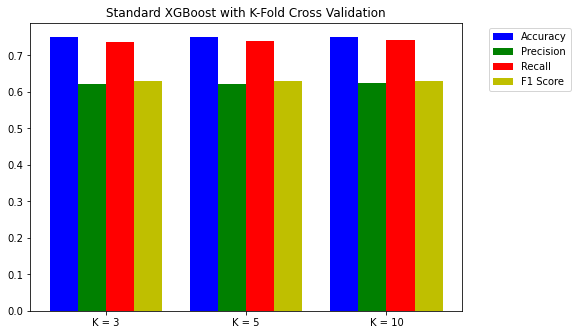

In [63]:
import matplotlib.pyplot as plt
data = [[avg_accuracy_kfcv3, avg_accuracy_kfcv5, avg_accuracy_kfcv10],
       [avg_precision_kfcv3, avg_precision_kfcv5, avg_precision_kfcv10],
       [avg_recall_kfcv3, avg_recall_kfcv5, avg_recall_kfcv10],
       [avg_f1_score_kfcv3, avg_f1_score_kfcv5, avg_f1_score_kfcv10]]
x = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
print(data[0])

ax.bar(x + 0.0, data[0], color = 'b', width = 0.2)
ax.bar(x + 0.2, data[1], color = 'g', width = 0.2)
ax.bar(x + 0.4, data[2], color = 'r', width = 0.2)
ax.bar(x + 0.6, data[3], color = 'y', width = 0.2)
ax.set_xticks(x + 0.3)
ax.set_title('Standard XGBoost with K-Fold Cross Validation')
ax.set_xticklabels(['K = 3', 'K = 5', 'K = 10'])
ax.legend(labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score'], bbox_to_anchor=(1.05, 1), loc='upper left')

## Stratified K-Fold Cross Validation for Standard XGBoost

In [64]:
from sklearn.model_selection import StratifiedKFold
skfcv3 = StratifiedKFold(n_splits=3,random_state=1, shuffle=True)
skfcv5 = StratifiedKFold(n_splits=5,random_state=1, shuffle=True)
skfcv10 = StratifiedKFold(n_splits=10,random_state=1, shuffle=True)

### Stratified 3-Fold Cross Validation

In [65]:
%%time
for train, test in skfcv3.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    xgb_model.fit(x_train_one_fold, y_train_one_fold)
    preds = xgb_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 15min 46s, sys: 1min 1s, total: 16min 48s
Wall time: 42.8 s


In [66]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(3):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.75998                0.62667                0.74308                0.63708
0.75501                0.62539                0.74396                0.6341
0.75036                0.62165                0.73785                0.62886


In [67]:
avg_accuracy_skfcv3 = sum(accuracy_list) / len(accuracy_list)
avg_precision_skfcv3 = sum(precision_list) / len(precision_list)
avg_recall_skfcv3 = sum(recall_list) / len(recall_list)
avg_f1_score_skfcv3 = sum(f1_score_list) / len(f1_score_list)

In [68]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### Stratified 5-Fold Cross Validation

In [69]:
%%time
for train, test in skfcv5.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    xgb_model.fit(x_train_one_fold, y_train_one_fold)
    preds = xgb_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 30min 43s, sys: 1min 58s, total: 32min 41s
Wall time: 1min 23s


In [70]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(5):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.75632                0.62293                0.73642                0.6322
0.75905                0.6259                0.74185                0.63601
0.74382                0.61952                0.73719                0.62441
0.75348                0.62378                0.74097                0.63202
0.7492                0.62082                0.7366                0.62765


In [71]:
avg_accuracy_skfcv5 = sum(accuracy_list) / len(accuracy_list)
avg_precision_skfcv5 = sum(precision_list) / len(precision_list)
avg_recall_skfcv5 = sum(recall_list) / len(recall_list)
avg_f1_score_skfcv5 = sum(f1_score_list) / len(f1_score_list)

In [72]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### Stratified 10-Fold Cross Validation

In [73]:
%%time
for train, test in skfcv10.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    xgb_model.fit(x_train_one_fold, y_train_one_fold)
    preds = xgb_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 1h 9min 5s, sys: 3min 54s, total: 1h 13min
Wall time: 3min 5s


In [74]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(10):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.75221                0.62192                0.73716                0.62978
0.74414                0.61534                0.72614                0.6206
0.75664                0.6268                0.74631                0.63604
0.76282                0.62895                0.7466                0.64027
0.74139                0.61954                0.73897                0.62348
0.75354                0.62468                0.74329                0.6329
0.74225                0.61661                0.73077                0.6211
0.75161                0.62396                0.74294                0.63151
0.76529                0.62894                0.74428                0.64107
0.74918                0.62034                0.73534                0.62718


In [75]:
avg_accuracy_skfcv10 = sum(accuracy_list) / len(accuracy_list)
avg_precision_skfcv10 = sum(precision_list) / len(precision_list)
avg_recall_skfcv10 = sum(recall_list) / len(recall_list)
avg_f1_score_skfcv10 = sum(f1_score_list) / len(f1_score_list)

In [76]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### Visualization of Results for Standard XGBoost using Stratified K-Fold Cross Validation

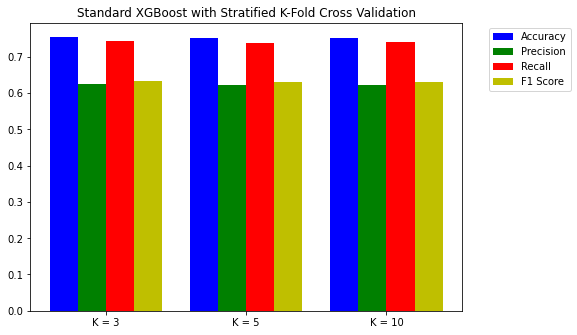

In [77]:
import matplotlib.pyplot as plt
data = [[avg_accuracy_skfcv3, avg_accuracy_skfcv5, avg_accuracy_skfcv10],
       [avg_precision_skfcv3, avg_precision_skfcv5, avg_precision_skfcv10],
       [avg_recall_skfcv3, avg_recall_skfcv5, avg_recall_skfcv10],
       [avg_f1_score_skfcv3, avg_f1_score_skfcv5, avg_f1_score_skfcv10]]
x = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(x + 0.0, data[0], color = 'b', width = 0.2)
ax.bar(x + 0.2, data[1], color = 'g', width = 0.2)
ax.bar(x + 0.4, data[2], color = 'r', width = 0.2)
ax.bar(x + 0.6, data[3], color = 'y', width = 0.2)
ax.set_xticks(x + 0.3)
ax.set_title('Standard XGBoost with Stratified K-Fold Cross Validation')
ax.set_xticklabels(['K = 3', 'K = 5', 'K = 10'])
ax.legend(labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score'], bbox_to_anchor=(1.05, 1), loc='upper left')

# **Building the Logistic Regression Model**

Here, we will be implementing Logistic regression to compare versus the XGBoost algorithms. Logistic Regression is a statistical analysis method used to predict a data value based on prior observations of a data set. This algorithm will be implemented using stratified k-fold cross validation and k-fold cross validation.

In [78]:
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report

lg_model = LogisticRegression(class_weight = "balanced", max_iter = 400)

accuracy_list = []
recall_list = []
precision_list = []
f1_score_list = []

## K-Fold Cross Validation for Logisitic Regression

In [79]:
from sklearn.model_selection import KFold
import numpy as np
kfcv3 = KFold(n_splits=3, random_state = 1, shuffle = True)
kfcv5 = KFold(n_splits=5, random_state = 1, shuffle = True)
kfcv10 = KFold(n_splits=10,  random_state = 1, shuffle = True)

### 3-Fold Cross Validation

In [80]:
%%time
for train, test in kfcv3.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    lg_model.fit(x_train_one_fold, y_train_one_fold.values.ravel())
    preds = lg_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 24.6 s, sys: 448 ms, total: 25.1 s
Wall time: 25.1 s


In [81]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(3):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.57372                0.53818                0.58657                0.48082
0.5745                0.53401                0.57752                0.47761
0.57128                0.53387                0.57819                0.47522


In [82]:
avg_accuracy_kfcv3 = sum(accuracy_list) / len(accuracy_list)
avg_precision_kfcv3 = sum(precision_list) / len(precision_list)
avg_recall_kfcv3 = sum(recall_list) / len(recall_list)
avg_f1_score_kfcv3 = sum(f1_score_list) / len(f1_score_list)

In [83]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### 5-Fold Cross Validation

In [84]:
%%time
for train, test in kfcv5.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    lg_model.fit(x_train_one_fold, y_train_one_fold.values.ravel())
    preds = lg_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 47.1 s, sys: 712 ms, total: 47.8 s
Wall time: 47.8 s


In [85]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(5):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.57529                0.53941                0.58943                0.48241
0.57041                0.53717                0.58411                0.47869
0.57204                0.53445                0.57857                0.47682
0.57698                0.53534                0.58105                0.47934
0.57214                0.53409                0.57923                0.47534


In [86]:
avg_accuracy_kfcv5 = sum(accuracy_list) / len(accuracy_list)
avg_precision_kfcv5 = sum(precision_list) / len(precision_list)
avg_recall_kfcv5 = sum(recall_list) / len(recall_list)
avg_f1_score_kfcv5 = sum(f1_score_list) / len(f1_score_list)

In [87]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### 10-Fold Cross Validation

In [88]:
%%time
for train, test in kfcv10.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    lg_model.fit(x_train_one_fold, y_train_one_fold.values.ravel())
    preds = lg_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 1min 34s, sys: 1.64 s, total: 1min 36s
Wall time: 1min 36s


In [89]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(10):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.57614                0.53801                0.58668                0.4814
0.57443                0.53895                0.58786                0.48207
0.56954                0.53803                0.58581                0.47913
0.57321                0.53613                0.5819                0.47906
0.56932                0.53315                0.57623                0.47405
0.57732                0.53714                0.58395                0.48185
0.57443                0.53306                0.57623                0.47607
0.57386                0.53702                0.58469                0.47942
0.57132                0.53565                0.58313                0.47595
0.57514                0.53611                0.5837                0.47841


In [90]:
avg_accuracy_kfcv10 = sum(accuracy_list) / len(accuracy_list)
avg_precision_kfcv10 = sum(precision_list) / len(precision_list)
avg_recall_kfcv10 = sum(recall_list) / len(recall_list)
avg_f1_score_kfcv10 = sum(f1_score_list) / len(f1_score_list)

### Visualization of Results for Logistic Regression using K-Fold Cross Validation

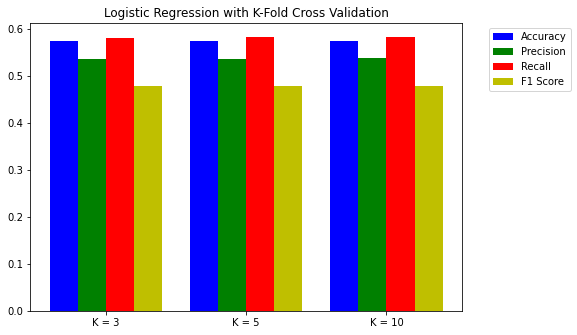

In [91]:
import matplotlib.pyplot as plt
data = [[avg_accuracy_kfcv3, avg_accuracy_kfcv5, avg_accuracy_kfcv10],
       [avg_precision_kfcv3, avg_precision_kfcv5, avg_precision_kfcv10],
       [avg_recall_kfcv3, avg_recall_kfcv5, avg_recall_kfcv10],
       [avg_f1_score_kfcv3, avg_f1_score_kfcv5, avg_f1_score_kfcv10]]
x = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(x + 0.0, data[0], color = 'b', width = 0.2)
ax.bar(x + 0.2, data[1], color = 'g', width = 0.2)
ax.bar(x + 0.4, data[2], color = 'r', width = 0.2)
ax.bar(x + 0.6, data[3], color = 'y', width = 0.2)
ax.set_xticks(x + 0.3)
ax.set_title('Logistic Regression with K-Fold Cross Validation')
ax.set_xticklabels(['K = 3', 'K = 5', 'K = 10'])
ax.legend(labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score'], bbox_to_anchor=(1.05, 1), loc='upper left')

## Stratified K-Fold Cross Validation for Logistic Regression

In [92]:
from sklearn.model_selection import StratifiedKFold
skfcv3 = StratifiedKFold(n_splits=3,random_state=1, shuffle=True)
skfcv5 = StratifiedKFold(n_splits=5,random_state=1, shuffle=True)
skfcv10 = StratifiedKFold(n_splits=10,random_state=1, shuffle=True)

### Stratified 3-Fold Cross Validation

In [93]:
%%time
for train, test in skfcv3.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    lg_model.fit(x_train_one_fold, y_train_one_fold.values.ravel())
    preds = lg_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 21.3 s, sys: 416 ms, total: 21.7 s
Wall time: 21.7 s


In [94]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(3):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.57614                0.53801                0.58668                0.4814
0.57443                0.53895                0.58786                0.48207
0.56954                0.53803                0.58581                0.47913


In [95]:
avg_accuracy_skfcv3 = sum(accuracy_list) / len(accuracy_list)
avg_precision_skfcv3 = sum(precision_list) / len(precision_list)
avg_recall_skfcv3 = sum(recall_list) / len(recall_list)
avg_f1_score_skfcv3 = sum(f1_score_list) / len(f1_score_list)

In [96]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### Stratified 5-Fold Cross Validation

In [97]:
%%time
for train, test in skfcv5.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    lg_model.fit(x_train_one_fold, y_train_one_fold.values.ravel())
    preds = lg_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 45.5 s, sys: 768 ms, total: 46.3 s
Wall time: 46.3 s


In [98]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(5):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.57393                0.53487                0.57965                0.47791
0.57366                0.53533                0.5807                0.47812
0.56702                0.53659                0.58393                0.47577
0.57246                0.53482                0.57959                0.47717
0.57623                0.53819                0.58726                0.48146


In [99]:
avg_accuracy_skfcv5 = sum(accuracy_list) / len(accuracy_list)
avg_precision_skfcv5 = sum(precision_list) / len(precision_list)
avg_recall_skfcv5 = sum(recall_list) / len(recall_list)
avg_f1_score_skfcv5 = sum(f1_score_list) / len(f1_score_list)

In [100]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### Stratified 10-Fold Cross Validation

In [101]:
%%time
for train, test in skfcv10.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    lg_model.fit(x_train_one_fold, y_train_one_fold.values.ravel())
    preds = lg_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 1min 34s, sys: 1.54 s, total: 1min 36s
Wall time: 1min 36s


In [102]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(10):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.57496                0.53447                0.57866                0.4781
0.57639                0.53696                0.58437                0.48063
0.57507                0.53559                0.58126                0.47899
0.57089                0.53683                0.58434                0.47786
0.575                0.53935                0.59003                0.4817
0.56479                0.5362                0.58309                0.47439
0.56936                0.53387                0.5775                0.47497
0.57207                0.53587                0.58203                0.47774
0.57546                0.53618                0.5826                0.47961
0.58054                0.5387                0.58823                0.48392


In [103]:
avg_accuracy_skfcv10 = sum(accuracy_list) / len(accuracy_list)
avg_precision_skfcv10 = sum(precision_list) / len(precision_list)
avg_recall_skfcv10 = sum(recall_list) / len(recall_list)
avg_f1_score_skfcv10 = sum(f1_score_list) / len(f1_score_list)

### Visualization of Results for Logistic Regression using Stratified K-Fold Cross Validation

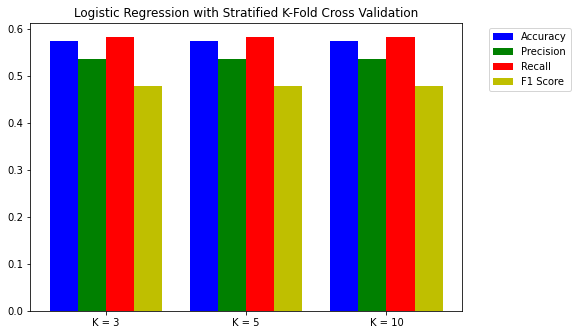

In [104]:
import matplotlib.pyplot as plt
data = [[avg_accuracy_skfcv3, avg_accuracy_skfcv5, avg_accuracy_skfcv10],
       [avg_precision_skfcv3, avg_precision_skfcv5, avg_precision_skfcv10],
       [avg_recall_skfcv3, avg_recall_skfcv5, avg_recall_skfcv10],
       [avg_f1_score_skfcv3, avg_f1_score_skfcv5, avg_f1_score_skfcv10]]
x = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(x + 0.0, data[0], color = 'b', width = 0.2)
ax.bar(x + 0.2, data[1], color = 'g', width = 0.2)
ax.bar(x + 0.4, data[2], color = 'r', width = 0.2)
ax.bar(x + 0.6, data[3], color = 'y', width = 0.2)
ax.set_xticks(x + 0.3)
ax.set_title('Logistic Regression with Stratified K-Fold Cross Validation')
ax.set_xticklabels(['K = 3', 'K = 5', 'K = 10'])
ax.legend(labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score'], bbox_to_anchor=(1.05, 1), loc='upper left')

# **Building the Random Forest Classifier** 

Below, we will be implementing a random forest classifier. This is a classifaction algorithm that is made up of multiple decision trees in order to predict. This will be implemented using stratified k-fold cross validation as well as k-fold cross validation.

In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report

rfc_model = RandomForestClassifier()



accuracy_list = []
recall_list = []
precision_list = []
f1_score_list = []

## K-Fold Cross Validation for Random Forest Classifier

In [106]:
from sklearn.model_selection import KFold
import numpy as np
kfcv3 = KFold(n_splits=3, random_state = 1, shuffle = True)
kfcv5 = KFold(n_splits=5, random_state = 1, shuffle = True)
kfcv10 = KFold(n_splits=10,  random_state = 1, shuffle = True)

### 3-Fold Cross Validation

In [107]:
%%time
for train, test in kfcv3.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    rfc_model.fit(x_train_one_fold, np.ravel(y_train_one_fold))
    preds = rfc_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 4min 21s, sys: 389 ms, total: 4min 22s
Wall time: 4min 22s


In [108]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(3):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.89186                0.75445                0.71309                0.73098
0.89107                0.75012                0.70609                0.72487
0.89287                0.75185                0.7075                0.72644


In [109]:
avg_accuracy_kfcv3 = sum(accuracy_list) / len(accuracy_list)
avg_precision_kfcv3 = sum(precision_list) / len(precision_list)
avg_recall_kfcv3 = sum(recall_list) / len(recall_list)
avg_f1_score_kfcv3 = sum(f1_score_list) / len(f1_score_list)

In [110]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### 5-Fold Cross Validation

In [111]:
%%time
for train, test in kfcv5.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    rfc_model.fit(x_train_one_fold, np.ravel(y_train_one_fold))
    preds = rfc_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 8min 48s, sys: 702 ms, total: 8min 48s
Wall time: 8min 48s


In [112]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(5):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.89282                0.75743                0.70953                0.72976
0.89141                0.75455                0.70943                0.72865
0.89071                0.7494                0.70643                0.72483
0.89432                0.75773                0.70797                0.72886
0.89223                0.74753                0.71133                0.72726


In [113]:
avg_accuracy_kfcv5 = sum(accuracy_list) / len(accuracy_list)
avg_precision_kfcv5 = sum(precision_list) / len(precision_list)
avg_recall_kfcv5 = sum(recall_list) / len(recall_list)
avg_f1_score_kfcv5 = sum(f1_score_list) / len(f1_score_list)

In [114]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### 10-Fold Cross Validation

In [115]:
%%time
for train, test in kfcv10.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    rfc_model.fit(x_train_one_fold, np.ravel(y_train_one_fold))
    preds = rfc_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 19min 48s, sys: 1.42 s, total: 19min 50s
Wall time: 19min 50s


In [116]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(10):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.89279                0.75573                0.70543                0.72645
0.89354                0.7616                0.71053                0.7319
0.89268                0.75902                0.71465                0.73367
0.89004                0.74967                0.7041                0.72339
0.89221                0.75143                0.70647                0.72561
0.88986                0.74952                0.70344                0.72291
0.89368                0.75388                0.70861                0.72791
0.89543                0.76272                0.71047                0.73228
0.89043                0.74208                0.70166                0.71908
0.89314                0.75123                0.706                0.72525


In [117]:
avg_accuracy_kfcv10 = sum(accuracy_list) / len(accuracy_list)
avg_precision_kfcv10 = sum(precision_list) / len(precision_list)
avg_recall_kfcv10 = sum(recall_list) / len(recall_list)
avg_f1_score_kfcv10 = sum(f1_score_list) / len(f1_score_list)

In [118]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### Visualization of Results for Random Forest Classifier using K-Fold Cross Validation

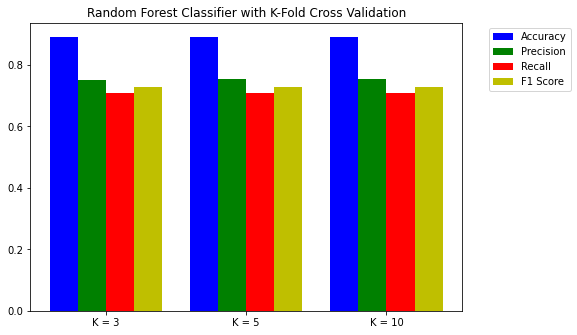

In [119]:
import matplotlib.pyplot as plt
data = [[avg_accuracy_kfcv3, avg_accuracy_kfcv5, avg_accuracy_kfcv10],
       [avg_precision_kfcv3, avg_precision_kfcv5, avg_precision_kfcv10],
       [avg_recall_kfcv3, avg_recall_kfcv5, avg_recall_kfcv10],
       [avg_f1_score_kfcv3, avg_f1_score_kfcv5, avg_f1_score_kfcv10]]
x = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(x + 0.0, data[0], color = 'b', width = 0.2)
ax.bar(x + 0.2, data[1], color = 'g', width = 0.2)
ax.bar(x + 0.4, data[2], color = 'r', width = 0.2)
ax.bar(x + 0.6, data[3], color = 'y', width = 0.2)
ax.set_xticks(x + 0.3)
ax.set_title('Random Forest Classifier with K-Fold Cross Validation')
ax.set_xticklabels(['K = 3', 'K = 5', 'K = 10'])
ax.legend(labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score'], bbox_to_anchor=(1.05, 1), loc='upper left')

## Stratified K-Fold Cross Validation for Random Forest Classifiers

In [120]:
from sklearn.model_selection import StratifiedKFold
skfcv3 = StratifiedKFold(n_splits=3,random_state=1, shuffle=True)
skfcv5 = StratifiedKFold(n_splits=5,random_state=1, shuffle=True)
skfcv10 = StratifiedKFold(n_splits=10,random_state=1, shuffle=True)

### Stratified 3-Fold Cross Validation

In [121]:
%%time
for train, test in skfcv3.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    rfc_model.fit(x_train_one_fold, np.ravel(y_train_one_fold))
    preds = rfc_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 4min 21s, sys: 429 ms, total: 4min 21s
Wall time: 4min 21s


In [122]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(3):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.89121                0.74994                0.71014                0.72741
0.89156                0.75118                0.70726                0.72602
0.89352                0.75663                0.71231                0.73131


In [123]:
avg_accuracy_skfcv3 = sum(accuracy_list) / len(accuracy_list)
avg_precision_skfcv3 = sum(precision_list) / len(precision_list)
avg_recall_skfcv3 = sum(recall_list) / len(recall_list)
avg_f1_score_skfcv3 = sum(f1_score_list) / len(f1_score_list)

In [124]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### Stratified 5-Fold Cross Validation

In [125]:
%%time
for train, test in skfcv5.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    rfc_model.fit(x_train_one_fold, np.ravel(y_train_one_fold))
    preds = rfc_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 8min 50s, sys: 658 ms, total: 8min 51s
Wall time: 8min 51s


In [126]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(5):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.89121                0.75017                0.70669                0.72528
0.89304                0.75542                0.70981                0.72924
0.89148                0.75127                0.70377                0.72377
0.894                0.75821                0.71142                0.7313
0.894                0.75809                0.71235                0.73187


In [127]:
avg_accuracy_skfcv5 = sum(accuracy_list) / len(accuracy_list)
avg_precision_skfcv5 = sum(precision_list) / len(precision_list)
avg_recall_skfcv5 = sum(recall_list) / len(recall_list)
avg_f1_score_skfcv5 = sum(f1_score_list) / len(f1_score_list)

In [128]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### Stratified 10-Fold Cross Validation

In [129]:
%%time
for train, test in skfcv10.split(X, Y):
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = Y.iloc[train], Y.iloc[test]
    rfc_model.fit(x_train_one_fold, np.ravel(y_train_one_fold))
    preds = rfc_model.predict(x_test_one_fold)
    precision_list.append(precision_score(y_test_one_fold, preds, average='macro', pos_label=1))
    recall_list.append(recall_score(y_test_one_fold, preds, average='macro', pos_label=1))
    f1_score_list.append(f1_score(y_test_one_fold, preds, average='macro', pos_label=1))
    accuracy_list.append(accuracy_score(y_test_one_fold, preds))

CPU times: user 19min 50s, sys: 1.31 s, total: 19min 51s
Wall time: 19min 51s


In [130]:
print('Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores')

for i in range(10):
    print(round(accuracy_list[i],5), '              ' , round(precision_list[i], 5), '              ', round(recall_list[i],5), '              ', round(f1_score_list[i], 5))

Accuracy_Scores ...... Precision_Scores ...... Recall_Scores ...... F1_Scores
0.89193                0.75221                0.70743                0.72651
0.89021                0.74759                0.70181                0.72115
0.8935                0.75657                0.71225                0.73124
0.89282                0.75539                0.70429                0.72556
0.89164                0.75224                0.69915                0.72099
0.89171                0.75134                0.71111                0.72856
0.89311                0.75601                0.70656                0.72731
0.89436                0.7596                0.70939                0.73046
0.89418                0.75849                0.71363                0.73284
0.89318                0.75568                0.71145                0.7304


In [131]:
avg_accuracy_skfcv10 = sum(accuracy_list) / len(accuracy_list)
avg_precision_skfcv10 = sum(precision_list) / len(precision_list)
avg_recall_skfcv10 = sum(recall_list) / len(recall_list)
avg_f1_score_skfcv10 = sum(f1_score_list) / len(f1_score_list)

In [132]:
accuracy_list.clear()
precision_list.clear()
recall_list.clear()
f1_score_list.clear()

### Visualization of Results for Random Forest Classifier using Stratified K-Fold Cross Validation

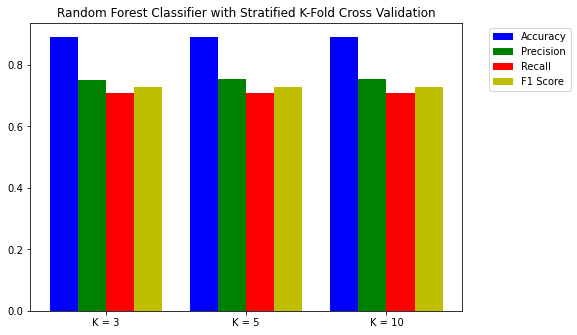

In [133]:
import matplotlib.pyplot as plt
data = [[avg_accuracy_skfcv3, avg_accuracy_skfcv5, avg_accuracy_skfcv10],
       [avg_precision_skfcv3, avg_precision_skfcv5, avg_precision_skfcv10],
       [avg_recall_skfcv3, avg_recall_skfcv5, avg_recall_skfcv10],
       [avg_f1_score_skfcv3, avg_f1_score_skfcv5, avg_f1_score_skfcv10]]
x = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(x + 0.0, data[0], color = 'b', width = 0.2)
ax.bar(x + 0.2, data[1], color = 'g', width = 0.2)
ax.bar(x + 0.4, data[2], color = 'r', width = 0.2)
ax.bar(x + 0.6, data[3], color = 'y', width = 0.2)
ax.set_xticks(x + 0.3)
ax.set_title('Random Forest Classifier with Stratified K-Fold Cross Validation')
ax.set_xticklabels(['K = 3', 'K = 5', 'K = 10'])
ax.legend(labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score'], bbox_to_anchor=(1.05, 1), loc='upper left')